In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lmfit import Model, Parameters
from tqdm.notebook import tqdm

from scripts.extensional_paras import fit_poly

In [2]:
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=0.7, rc={'grid.linewidth': 0.5})

In [3]:
def fsize_cm(size_x, size_y):
    """
    
    :param size_x: Figure width in inch
    :param size_y: Figure height in inch
    :return: tuple(width, height) in cm
    """
    return size_x / 2.54, size_y / 2.54

##### Stress functions

In [4]:
def kv_strain_poly_stress_from_int(t, lmbda, viscosity, strain_0, stress_poly, offset=0):
    strains = []
    for tt in t:
        x = np.linspace(0, tt, 100)
        integral = np.trapz(stress_poly(x) * np.exp(lmbda*x), x=x)
        sum_part_2 = integral / viscosity
        strains.append(np.exp(-lmbda * tt) * (strain_0 + sum_part_2) + offset)
    return strains

def kv_strain_poly_stress_from_int_global_p(t, lmbda, viscosity, strain_0,
                                            offset):
    global p
    strains = []
    for tt in t:
        x = np.linspace(0, tt, 100)
        integral = np.trapz(p(x) * np.exp(lmbda*x), x=x)
        sum_part_2 = integral / viscosity
        strains.append(np.exp(-lmbda * tt) * (strain_0 + sum_part_2) + offset)
    return strains

In [5]:
def log_logistic_fct(x, steepness, lower_bound, upper_bound, inflection_point):
    """Return log-logistic function for x with paras:
    steepness: steepness of the increase
    lower_bound: lower limit of the function
    upper_bound: upper limit of the function
    inflection_point: inflection point of the function
    """
    return lower_bound + (upper_bound - lower_bound) \
           / (1 + np.exp(steepness*(np.log(x) - np.log(inflection_point))))

Load data

In [6]:
save_med_path = "..\\data\\20231123_hl60_latb\\hl60_latb_median_data_20240226.tsv"
df_median = pd.read_csv(save_med_path, sep='\t', index_col=0)

In [7]:
time_feat = 'time_shift'
strain_feat = 'net_strain_inert'
stress_feat = 'stress_net_ir'

### Kelvin-Voigt analysis for full stress curve

##### Get stress functions

In [8]:
dates = df_median['date'].unique()
flow_rates = df_median['flow_rate'].unique()
concentrations = df_median['LatB concentration'].unique()

stress_polys = {}

for date in tqdm(dates, desc='Dates: '):
    for fr in flow_rates:
        for cc in concentrations:
            df = df_median.loc[(df_median['date'] == date) 
                               & (df_median['flow_rate'] == fr) 
                               & (df_median['LatB concentration'] == cc)]
            if len(df) > 0:
                x = df[time_feat].to_numpy()
                y = df[stress_feat].to_numpy()

                key = "{}_{}_{}".format(date, fr, cc)
                stress_polys[key] = fit_poly(x, y, 8)

Dates:   0%|          | 0/3 [00:00<?, ?it/s]

Fit KV model to the strain curves

In [9]:
df_kv_fit = pd.DataFrame()
for date in tqdm(dates, desc='Dates: '):
    for fr in flow_rates:
        for cc in concentrations:
            df = df_median.loc[(df_median['date'] == date)
                               & (df_median['flow_rate'] == fr)
                               & (df_median['LatB concentration'] == cc)]
            if len(df) > 0:
                time = df[time_feat].to_numpy()
                strain = df[strain_feat].to_numpy()
                # sort for time to get clean plot
                idx = np.argsort(time)
                time = time[idx]
                strain = strain[idx]

                # define parameters that the fit models will use
                params = Parameters()
                params.add('viscosity', value=2, min=0.01, max=20)
                params.add('lmbda', value=100, min=1, max=600)
                # construct max strain_0 and max offset based on the stress 
                # value at x_0
                # assume a minimum Young's modulus based of 80 Pa
                e_min = 80
                stress_0 = df[stress_feat].iloc[0]
                strain_0_max = stress_0 / e_min
                strain_0 = 0.5 * strain_0_max
                strain_0_min = 0.2 * strain_0
                params.add('strain_0', value=strain_0,
                           min=strain_0_min, max=strain_0_max)
                offset_0 = strain[:5].min()
                # offset_max = 1.2 * (offset_0 - strain_0_max)
                offset_max = 1.2 * offset_0
                if offset_max < 0.01:
                    offset_max = 0.01
                params.add('offset', value=offset_max/2, min=0, max=offset_max)

                # add stress polynomial factors
                key = "{}_{}_{}".format(date, fr, cc)
                p = stress_polys[key]

                # create fit model
                fmodel = Model(kv_strain_poly_stress_from_int_global_p)

                fit_result = fmodel.fit(strain, params, t=time, nan_policy='propagate')
                df_fit_paras = pd.DataFrame()
                df_fit_paras['date'] = [date]
                df_fit_paras['flow_rate'] = [fr]
                df_fit_paras['concentration'] = [cc]
                df_fit_paras['stress_0'] = stress_0
                fit_paras = ['viscosity', 'lmbda', 'strain_0', 'offset']
                for ii, para in enumerate(fit_paras):
                    df_fit_paras[para] = [fit_result.best_values[para]]
                    df_fit_paras[para + '_err'] = fit_result.params[para].stderr
                    df_fit_paras[para + '_err_rel'] = (df_fit_paras[para + '_err']
                                                       / df_fit_paras[para])
                df_kv_fit = pd.concat([df_kv_fit, df_fit_paras])
df_kv_fit.reset_index(inplace=True, drop=True)

Dates:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
visc = df_kv_fit['viscosity']
visc_err = df_kv_fit['viscosity_err']
lmbda = df_kv_fit['lmbda']
lmbda_err = df_kv_fit['lmbda_err']
df_kv_fit['emodulus'] = visc * lmbda
df_kv_fit['emodulus_err'] = np.sqrt((visc * lmbda_err) ** 2 + (lmbda * visc_err) ** 2)
df_kv_fit['relaxation_time'] = 1 / lmbda
df_kv_fit['relaxation_time_err'] = lmbda_err / lmbda ** 2
df_kv_fit['strain_0_expect'] = df_kv_fit['stress_0'] / df_kv_fit['emodulus']

##### Plot the resulting KV curves

In [27]:
dates = df_median['date'].unique()
flow_rates = np.sort(df_median['flow_rate'].unique())
concentrations = np.sort(df_median['LatB concentration'].unique())

n_rows = len(concentrations)
n_cols = len(flow_rates)
colors = sns.color_palette('tab10', len(dates))
stress_color = 'tab:red'
fsize = fsize_cm(17,25)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=fsize, sharex='col')
# create array with twin axes
axes_tw = np.empty_like(axes)
for jj in range(n_rows):
    for ii in range(n_cols):
        ax = axes[jj, ii]
        axes_tw[jj, ii] = ax.twinx()
        
for ll, date in enumerate(dates):
    for ii, fr in enumerate(flow_rates):
        for jj, cc in enumerate(concentrations):
            df = df_median.loc[(df_median['date'] == date) 
                               & (df_median['flow_rate'] == fr) 
                               & (df_median['LatB concentration'] == cc)]
            ax = axes[jj, ii]
            ax.set_title("Concentration = {} nM | Flow rate = {} µl/s".format(cc, fr),
                         fontsize=5)
            ax_tw = axes_tw[jj, ii]
            
            if len(df) > 0:
                x = df[time_feat].to_numpy()
                y = df[strain_feat].to_numpy()
                ax.plot(x *1e3, y, 'o', markersize=3, color=colors[ll], alpha=.9, 
                        markeredgewidth=0.1, markeredgecolor='w', 
                        label=date, zorder=2)

                stress = df[stress_feat].to_numpy()
                ax_tw.plot(x *1e3, stress, '--', lw=1.5, color=colors[ll],
                           alpha=0.8, label="Stress", zorder=2)
                ax_tw.grid()
                
                kv_paras = df_kv_fit.loc[(df_kv_fit['date'] == date)
                                         & (df_kv_fit['flow_rate'] == fr)
                                         & (df_kv_fit['concentration'] == cc)
                                         ]
                if len(kv_paras) > 0:
                    key = "{}_{}_{}".format(date, fr, cc)
                    p = stress_polys[key]
                    y_kv = kv_strain_poly_stress_from_int(x,
                                                          kv_paras['lmbda'].iloc[0],
                                                          kv_paras['viscosity'].iloc[0],
                                                          kv_paras['strain_0'].iloc[0],
                                                          p,
                                                          offset=kv_paras['offset'].iloc[0])
                    ax.plot(x *1e3, y_kv, ls='-', c='k', lw=0.8, zorder=10)
                    ax.plot(x *1e3, y_kv, ls='-', c=colors[ll], lw=0.25, zorder=12)

for ii, fr in enumerate(flow_rates):
    for jj, cc in enumerate(concentrations):
        ax = axes[jj, ii]
        ax.tick_params(labelsize=5)
        ax.set_ylim(0)
        ax_tw = axes_tw[jj, ii]
        ax_tw.tick_params(labelsize=5, color=stress_color, labelcolor=stress_color)
        ax_tw.set_ylim(0)

axes[-1, -1].legend(fontsize=6, frameon=False, handletextpad=0.3,
                    title="Date", title_fontsize=6, alignment='right',
                    borderpad=0.1, markerscale=1.3
                    )

label_fontsize=8
fig.supxlabel("Time [ms]", fontsize=label_fontsize)
fig.text(0, 0.5, "Strain", fontsize=label_fontsize, rotation=90, ha='center')
fig.text(1, 0.5, "Stress [Pa]", fontsize=label_fontsize, rotation=90, ha='center',
         color=stress_color)

plt.tight_layout()
plt.show()

# save_path = "..\\figure_plots\\SI\\fig_s6_hl60_latb_strain_stress_time.pdf"
# fig.savefig(save_path, format='pdf', dpi=900,
#             bbox_inches='tight', pad_inches=fsize[0] / 200
#             )

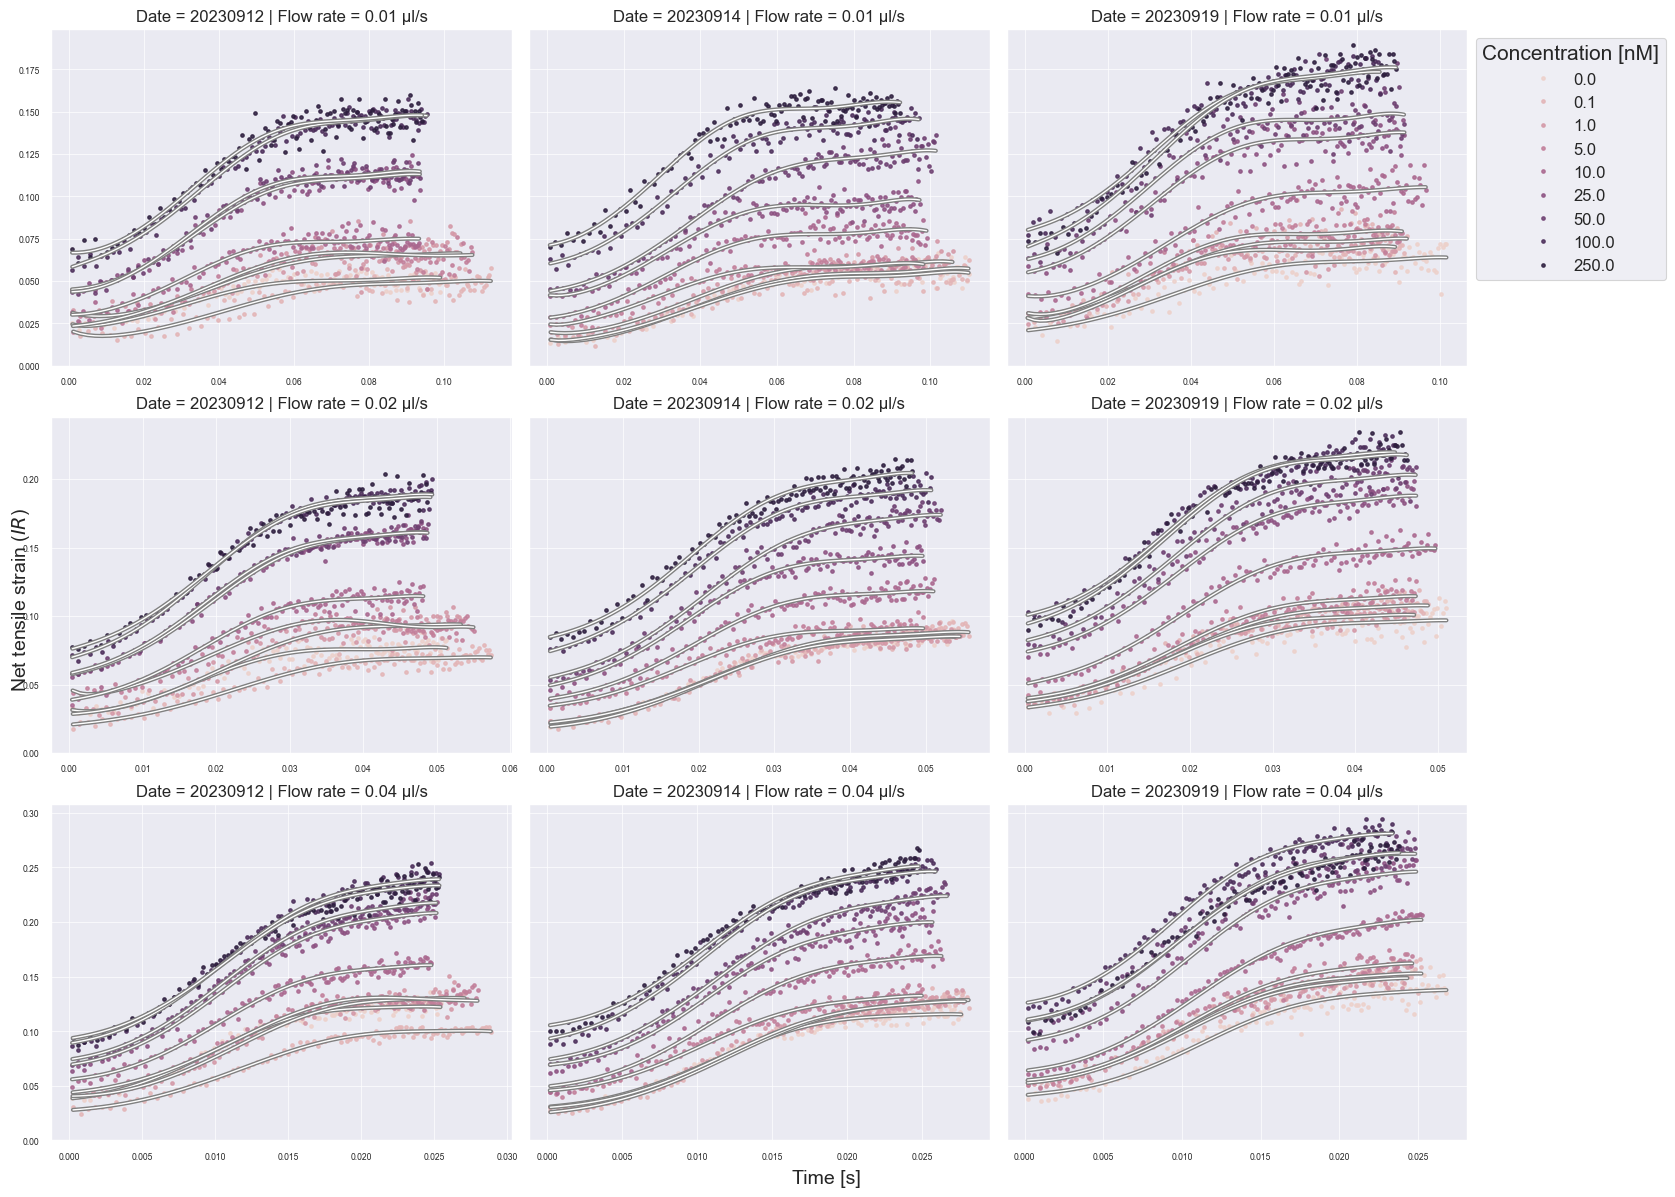

In [12]:
dates = df_median['date'].unique()
flow_rates = np.sort(df_median['flow_rate'].unique())
concentrations = np.sort(df_median['LatB concentration'].unique())

n_cols = len(dates)
colors = sns.color_palette('ch:', len(concentrations))
fig, axes = plt.subplots(nrows=len(flow_rates), ncols=n_cols,
                         figsize=(17,12), sharey='row')
for ll, date in enumerate(dates):
    for ii, fr in enumerate(flow_rates):
        for jj, cc in enumerate(concentrations):
            df = df_median[df_median['date'] == date]
            df = df[df['flow_rate'] == fr]
            df = df[df['LatB concentration'] == cc]

            ax = axes[ii, ll]
            ax.set_title("Date = {} | Flow rate = {} µl/s".format(date, fr),
                         fontsize=12)
            if len(df) > 0:
                x = df[time_feat].to_numpy()
                y = df[strain_feat].to_numpy()
                ax.plot(x, y, '.', color=colors[jj], alpha=.85, zorder=1, label=cc)

                kv_paras = df_kv_fit.loc[(df_kv_fit['date'] == date)
                                         & (df_kv_fit['flow_rate'] == fr)
                                         & (df_kv_fit['concentration'] == cc)
                                         ]
                if len(kv_paras) > 0:
                    key = "{}_{}_{}".format(date, fr, cc)
                    p = stress_polys[key]
                    y_kv = kv_strain_poly_stress_from_int(x,
                                                          kv_paras['lmbda'].iloc[0],
                                                          kv_paras['viscosity'].iloc[0],
                                                          kv_paras['strain_0'].iloc[0],
                                                          p,
                                                          offset=kv_paras['offset'].iloc[0])
                    ax.plot(x, y_kv, ls='-', c='gray', lw=3)
                    ax.plot(x, y_kv, ls='-', c='w', lw=1)
# set ylim=0 in each row in the figure
for ax in axes[:, 0]:
    ax.set_ylim(0)

axes[0, -1].legend(title='Concentration [nM]', title_fontsize=15, fontsize=12,
                   loc='upper left', bbox_to_anchor=[1,1])
fig.supxlabel("Time [s]", fontsize=14)
fig.supylabel("Net tensile strain ($IR$)", fontsize=14)

plt.tight_layout()
plt.show()

Plot fit curves for one condition: `date==20230914 & flow_rate==0.02`

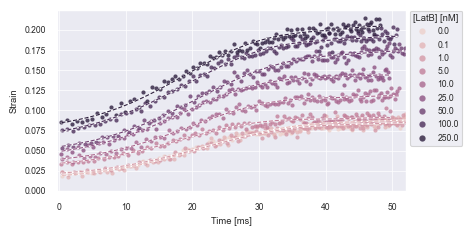

In [13]:
date = 20230914
flow_rate = 0.02
df_plot = df_median.loc[(df_median['date'] == 20230914) & (df_median['flow_rate'] == 0.02)]
concentrations = np.sort(df_plot['LatB concentration'].unique())

colors = sns.color_palette('ch:', len(concentrations))
fsize = fsize_cm(12, 6)
fig, ax = plt.subplots(1, 1, figsize=fsize)
for jj, cc in enumerate(concentrations):
    df = df_plot.loc[df_plot['LatB concentration'] == cc]
    if len(df) > 0:
        t = df[time_feat].to_numpy()
        y = df[strain_feat].to_numpy()
        ax.plot(t *1e3, y, 'o', color=colors[jj], alpha=.8, 
                markersize=3, markeredgewidth=0, markeredgecolor='w',
                zorder=1, label=cc)

        kv_paras = df_kv_fit.loc[(df_kv_fit['date'] == date)
                                 & (df_kv_fit['flow_rate'] == flow_rate)
                                 & (df_kv_fit['concentration'] == cc)
                                 ]
        if len(kv_paras) > 0:
            key = "{}_{}_{}".format(date, flow_rate, cc)
            p = stress_polys[key]
            y_kv = kv_strain_poly_stress_from_int(t,
                                                  kv_paras['lmbda'].iloc[0],
                                                  kv_paras['viscosity'].iloc[0],
                                                  kv_paras['strain_0'].iloc[0],
                                                  p,
                                                  offset=kv_paras['offset'].iloc[0])
            ax.plot(t *1e3, y_kv, ls='-', c='w', lw=1)
            ax.plot(t *1e3, y_kv, ls='--', c=colors[jj], lw=0.8)

ax.set_xlim(-0.2, 52)
ax.set_ylim(0)

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Strain")

ax.legend(title='[LatB] [nM]', alignment='center',
          loc='upper left', bbox_to_anchor=[1, 1.02], markerscale=1.5)

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_strain_curve.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

Fit a log-logistic growth function to the Young's modulus data

In [14]:
emod_curves = pd.DataFrame()
# create fit model
fmodel = Model(log_logistic_fct)
# define parameters that the fit models will use
params = Parameters()
params.add('steepness', value=2., min=0.1, max=10)
params.add('lower_bound', value=100, min=50, max=300)
params.add('upper_bound', value=200, min=100, max=600)
params.add('inflection_point', value=10, min=0.01, max=1000)

for flow_rate in [0.01, 0.02, 0.04]:
    df_fr = df_kv_fit.loc[df_kv_fit['flow_rate']==flow_rate]
    x_data = df_fr['concentration'].to_numpy()
    y_data = df_fr['emodulus'].to_numpy()
    # sort for time to get clean plot
    idx = np.argsort(x_data)
    x_data = x_data[idx]
    y_data = y_data[idx]

    fit_result = fmodel.fit(y_data, params, x=x_data, max_nfev=10000)

    df_fit_paras = pd.DataFrame()
    df_fit_paras['flow_rate'] = [flow_rate]
    df_fit_paras['steepness'] = [fit_result.best_values['steepness']]
    df_fit_paras['lower_bound'] = [fit_result.best_values['lower_bound']]
    df_fit_paras['upper_bound'] = [fit_result.best_values['upper_bound']]
    ec50 = fit_result.best_values['inflection_point']
    df_fit_paras['EC50 [nM]'] = [ec50]
    
    fit_paras = ['steepness', 'lower_bound', 'upper_bound', 'inflection_point']
    for para in fit_paras:
        df_fit_paras[para] = [fit_result.best_values[para]]
        df_fit_paras[para + '_err'] = fit_result.params[para].stderr
        df_fit_paras[para + '_err_rel'] = (df_fit_paras[para + '_err']
                                           / df_fit_paras[para])
    emod_curves = pd.concat([emod_curves, df_fit_paras])

    x_fit = np.logspace(-2, 3, 100)
    y_fit = fit_result.eval(x=x_fit)
    y_ec50 = fit_result.eval(x=ec50)

emod_curves.set_index('flow_rate', inplace=True)

C:\Users\freiche\AppData\Local\Temp\ipykernel_10524\2519920780.py:9: RuntimeWarning: divide by zero encountered in log
  / (1 + np.exp(steepness*(np.log(x) - np.log(inflection_point))))
C:\Users\freiche\AppData\Local\Temp\ipykernel_10524\2519920780.py:9: RuntimeWarning: divide by zero encountered in log
  / (1 + np.exp(steepness*(np.log(x) - np.log(inflection_point))))
C:\Users\freiche\AppData\Local\Temp\ipykernel_10524\2519920780.py:9: RuntimeWarning: divide by zero encountered in log
  / (1 + np.exp(steepness*(np.log(x) - np.log(inflection_point))))


In [15]:
emod_curves

steepness  lower_bound  upper_bound  EC50 [nM]  steepness_err  \
flow_rate                                                                  
0.01        1.487499    80.534424   183.248671  12.722457       0.606078   
0.02        3.467868   136.241319   254.013079   9.752433       2.101799   
0.04        3.320678   210.735320   349.354110   8.995511       1.847291   

           steepness_err_rel  lower_bound_err  lower_bound_err_rel  \
flow_rate                                                            
0.01                0.407448        10.986493             0.136420   
0.02                0.606078         7.698217             0.056504   
0.04                0.556299         9.485064             0.045009   

           upper_bound_err  upper_bound_err_rel  inflection_point  \
flow_rate                                                           
0.01              7.233328             0.039473         12.722457   
0.02              8.011219             0.031539          9.752433   
0.04             10.140581             0.029027          8.995511   

           inflection_point_err  inflection_point_err_rel  
flow_rate                                                  
0.01                   3.955600                  0.310915  
0.02                   1.435620                  0.147206  
0.04                   1.467366                  0.163122

In [16]:
emod_curves.loc[0.02, 'steepness']

3.4678677569198597

#### Plot resulting Kelvin-Voigt parameters with flow rate as hue

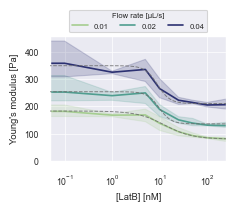

In [25]:
fsize = fsize_cm(6, 5.4)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.lineplot(data=df_kv_fit, x='concentration', y='emodulus',
             hue='flow_rate', palette='crest',
             errorbar=('pi', 100), ax=ax
             )
ax.set(xscale='log')
ax.set_xlim(0.05, 250)
ax.set_ylim(0)

x_fit = np.logspace(-2, 3, 100)
for flow_rate in [0.01, 0.02, 0.04]:
    steep = emod_curves.loc[flow_rate, 'steepness']
    low = emod_curves.loc[flow_rate, 'lower_bound']
    up = emod_curves.loc[flow_rate, 'upper_bound']
    ec50 = emod_curves.loc[flow_rate, 'inflection_point']
    y_fit = log_logistic_fct(x_fit, steep, low, up, ec50)
    ax.plot(x_fit, y_fit, c='dimgray', ls='--', lw=0.7, alpha=0.8, zorder=10)

ax.set_xlabel('[LatB] [nM]')
ax.set_ylabel('Young\'s modulus [Pa]')

ax.legend(title="Flow rate [µL/s]", title_fontsize=5.5,
          fontsize=5.5,
          loc='lower center', bbox_to_anchor=[0.5, 1], 
          ncol=3, columnspacing=1.5
          )

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_emodulus.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

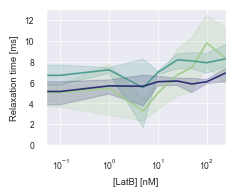

In [18]:
fsize = fsize_cm(6, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

df_kv_fit['tau [ms]'] = df_kv_fit['relaxation_time'] *1e3
sns.lineplot(data=df_kv_fit, x='concentration', y='tau [ms]',
             hue='flow_rate', palette='crest',
             errorbar=('pi', 100), ax=ax, legend=False
             )
ax.set(xscale='log')
ax.set_xlim(0.05, 250)
ax.set_ylim(0)
ax.set_xlabel('[LatB] [nM]')
ax.set_ylabel('Relaxation time [ms]')

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_relaxation_time.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

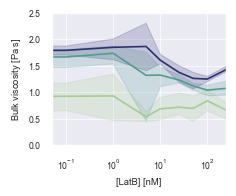

In [19]:
fsize = fsize_cm(6, 5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.lineplot(data=df_kv_fit, x='concentration', y='viscosity',
             hue='flow_rate', palette='crest',
             errorbar=('pi', 100), ax=ax, legend=False
             )
ax.set(xscale='log')
ax.set_xlim(0.05, 250)
ax.set_ylim(0, 2.5)
ax.set_xlabel('[LatB] [nM]')
ax.set_ylabel('Bulk viscosity [Pa$\,$s]')

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_viscosity.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

## Plot strain correction at inlet

In [20]:
data_folder = os.path.join("..", "data", "20231123_hl60_latb", "inlet_latb")

print("Reading in data 20230912")
path_20230912_inlet = os.path.join(data_folder,
                                   "20230913_hl60_latb_inlet.tsv")
df_20230912_inlet = pd.read_csv(path_20230912_inlet, sep='\t', index_col=0)

print("Reading in data 20230914")
path_20230914_inlet = os.path.join(data_folder,
                                   "20230915_hl60_latb_inlet.tsv")
df_20230914_inlet = pd.read_csv(path_20230914_inlet, sep='\t', index_col=0)

print("Reading in data 20230919")
path_20230919_inlet = os.path.join(data_folder,
                                   "20230919_hl60_latb_inlet.tsv")
df_20230919_inlet = pd.read_csv(path_20230919_inlet, sep='\t', index_col=0)

print("Done")

Reading in data 20230912
Reading in data 20230914
Reading in data 20230919
Done


In [21]:
df_inlet_all = pd.concat([df_20230912_inlet,
                          df_20230914_inlet,
                          df_20230919_inlet
                          ], ignore_index=True)
df_inlet_all['date'] = df_inlet_all['date'].astype(int)

In [22]:
df_inlet_all['net_strain_inert'] = ((df_inlet_all['inert_ratio_raw'] - 1)
                                    / np.sqrt(df_inlet_all['inert_ratio_raw']))

In [23]:
x_feat = 'pos_x'
n_bins = 120
# need to iterate over all dates, concentrations
# to create bins then concatenate to big dataframe again
df_median_inlet = pd.DataFrame()
dates = df_inlet_all['date'].unique()
for date in dates:
    df_date = df_inlet_all.loc[df_inlet_all['date'] == date]
    for concentration in df_date['LatB concentration'].unique():
        df_cc = df_date.loc[df_date['LatB concentration'] == concentration]
        bins = pd.cut(df_cc[x_feat], n_bins)
        df_grouped = df_cc.groupby(by=['LatB concentration', bins],
                                   as_index=False, observed=False
                                   )
        df_median_inlet = pd.concat([df_median_inlet, df_grouped.median()], ignore_index=True)
df_median_inlet.reset_index(inplace=True, drop=True)
df_median_inlet['date'] = df_median_inlet['date'].astype(int)

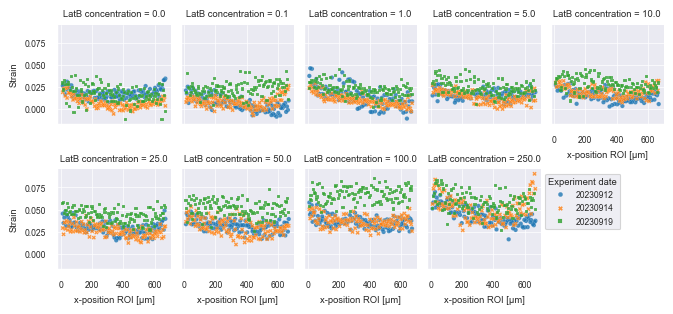

In [24]:
fsize = fsize_cm(17, 4)
n_cols = 5
aspect = fsize[0] / (fsize[1] * n_cols)
g = sns.relplot(data=df_median_inlet, x='x_inlet', y='net_strain_inert',
                height=fsize[1], aspect=aspect,
                hue='date', palette='tab10', alpha=0.8,
                style='date',
                col='LatB concentration', col_wrap=n_cols,
                kind='scatter', s=10, linewidth=0.1,
                facet_kws={'legend_out': False})
g.set_xlabels("x-position ROI [µm]")
g.set_ylabels("Strain")

ax0 = g.axes[0]
handles, labels = ax0.get_legend_handles_labels()
ax0.legend_ = None

ax_nn = g.axes[-1]
ax_nn.legend(handles, labels, 
             title="Experiment date",
             loc='upper left', bbox_to_anchor=[1,1])

# plt.tight_layout()
plt.show()

fig = g.figure
save_path = "..\\figure_plots\\SI\\fig_s5_latb_inlet.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )